In [ ]:
!chmod 600 ~/.passwd-s3fs

In [ ]:
!apt install s3fs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 200 kB of archives.
After this operation, 557 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 s3fs amd64 1.82-1 [200 kB]
Fetched 200 kB in 1s (380 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.82-1_amd64.deb ...
Unpacking s3fs (1.82-1) ...
Setting up s3fs (1.82-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!mkdir /content/s3
!s3fs um2ii-datasets /content/s3

In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics

 MIMIC Race Validation on MIMIC Test Set

In [ ]:
df = pd.read_csv('/content/mimic_race_split.csv')
df['path'] = 's3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
mimic_race_model = load_learner('/content/mimic_race.pkl')

In [ ]:
mimic_race_model.dls.to(device='cuda')
mimic_race_model.model.to(device='cuda')
race_test_dl = mimic_race_model.dls.test_dl(test_df)
race_preds = mimic_race_model.get_preds(dl=race_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Race/Ethnicity'] = test_df[['Race/Ethnicity']]
predict_df['Race/Ethnicity_Tensor_Id'] =race_preds[2].numpy()
predict_df['Race/Ethnicity_Probability'] =race_preds[0].numpy().tolist()

In [ ]:
mimic_race_model.dls.vocab

['Asian', 'Black', 'Hispanic/Latino', 'Other', 'White']

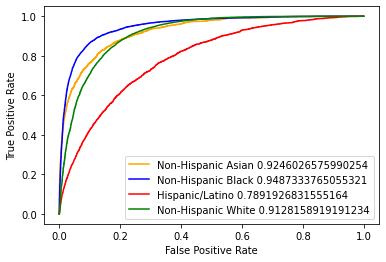

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[0] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Asian')
plt.plot(fpr,tpr, color='orange', label='Non-Hispanic Asian ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[1] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Black')
plt.plot(fpr,tpr, color='blue', label='Non-Hispanic Black ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[2] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Hispanic/Latino')
plt.plot(fpr,tpr, color='red', label='Hispanic/Latino ' + str(metrics.auc(fpr, tpr)))
#fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[3] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Other')
#plt.plot(fpr,tpr, color='black', label='Other ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[4] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'White')
plt.plot(fpr,tpr, color='green', label='Non-Hispanic White ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Race/Ethnicity_Tensor_Id', race_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Race/Ethnicity_Probability', race_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/mimic_race_mimic_test.csv')

         index                                      dicom_id  subject_id  \
4            4  d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738    10000935   
5            6  9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b    10000935   
6            8  8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30    10000935   
7           10  88498b37-c21dc7ba-bc202800-b517a62d-f7ac5bcf    10000935   
113        417  5f4d8dbd-5b3fabc2-57368426-c8a47b2a-25c294da    10005368   
...        ...                                           ...         ...   
200710  630232  ceb2632f-cc6434ff-14460cfb-0c0e00aa-01ea9dd9    19995320   
200711  630234  d989c09f-ef372efe-201d2a05-63d9c571-f6fda824    19995320   
200748  630338  e3e5f8c3-14429887-b1181522-445ec3a8-110663c3    19998562   
200749  630339  b70ca192-74b20b3e-669f166c-beec4177-2ece8df2    19998562   
200750  630340  12fad032-cf4eff00-32a4fc65-67e424b6-a2e42afb    19998562   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
4       505789

Chexpert Race v2 Validation on MIMIC Test Set

In [ ]:
df = pd.read_csv('/content/mimic_race_split.csv')
df['path'] = 's3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
chexpert_race2_model = load_learner('/content/chexpert_race2.pkl')

In [ ]:
chexpert_race2_model.dls.to(device='cuda')
chexpert_race2_model.model.to(device='cuda')
race_test_dl = chexpert_race2_model.dls.test_dl(test_df)
race_preds = chexpert_race2_model.get_preds(dl=race_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Race/Ethnicity'] = test_df[['Race/Ethnicity']]
predict_df['Race/Ethnicity_Tensor_Id'] =race_preds[2].numpy()
predict_df['Race/Ethnicity_Probability'] =race_preds[0].numpy().tolist()

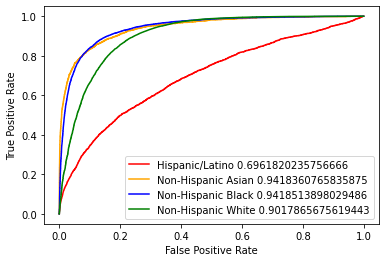

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[0] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Hispanic/Latino')
plt.plot(fpr,tpr, color='red', label='Hispanic/Latino ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[1] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Asian')
plt.plot(fpr,tpr, color='orange', label='Non-Hispanic Asian ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[2] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'Black')
plt.plot(fpr,tpr, color='blue', label='Non-Hispanic Black ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Race/Ethnicity'],y_score = [prob[3] for prob in predict_df['Race/Ethnicity_Probability']], pos_label = 'White')
plt.plot(fpr,tpr, color='green', label='Non-Hispanic White ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Race/Ethnicity_Tensor_Id', race_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Race/Ethnicity_Probability', race_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/chexpert_race2_mimic_test.csv')

         index                                      dicom_id  subject_id  \
4            4  d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738    10000935   
5            6  9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b    10000935   
6            8  8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30    10000935   
7           10  88498b37-c21dc7ba-bc202800-b517a62d-f7ac5bcf    10000935   
113        417  5f4d8dbd-5b3fabc2-57368426-c8a47b2a-25c294da    10005368   
...        ...                                           ...         ...   
200710  630232  ceb2632f-cc6434ff-14460cfb-0c0e00aa-01ea9dd9    19995320   
200711  630234  d989c09f-ef372efe-201d2a05-63d9c571-f6fda824    19995320   
200748  630338  e3e5f8c3-14429887-b1181522-445ec3a8-110663c3    19998562   
200749  630339  b70ca192-74b20b3e-669f166c-beec4177-2ece8df2    19998562   
200750  630340  12fad032-cf4eff00-32a4fc65-67e424b6-a2e42afb    19998562   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
4       505789